In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_master_encoded = pd.read_csv("./data/master/master_apartaments_data_encoded.csv", index_col = None, header=0)


In [ ]:
# 1. Definicja X i Y

# Zmienna docelowa Y: używamy logarytmu ceny, aby ustabilizować wariancję
Y = df_master_encoded['log_price'] 

# X: usuwamy oryginalną price, log_price (bo to Y), price_per_sqm (zbyt silny predyktor)
# oraz wszystkie oryginalne kolumny kategoryczne, które zostały zakodowane.
cols_to_drop = ['id', 'price', 'log_price', 'price_per_sqm', 
                'dataDate', 'buildYear', 'latitude', 'longitude',
                'ownership', 'hasParkingSpace', 'hasBalcony', 'hasSecurity', 'hasStorageRoom']
# Pamiętaj, aby usunąć wszystkie oryginalne kolumny, które służyły do kodowania
# (np. 'city', 'type', 'buildingEra', 'condition', itd.)

# Upewnij się, że usuniesz tylko kolumny, które faktycznie istnieją w df_master_encoded
X = df_master_encoded.drop(columns=[col for col in cols_to_drop if col in df_master_encoded.columns], axis=1)

# Usunięcie pozostałych kolumn kategorycznych, które nie zostały usunięte w cols_to_drop
# Upewnij się, że kolumny kategoryczne (np. 'city', 'type') zostały usunięte z X.

# Jeśli Twoje kolumny 'city_Unknown', 'city_Warszawa', itd. są w X, to jest OK.

# 2. Podział na zbiór treningowy i testowy
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42 # Zapewnia powtarzalność wyników
)

print(f"Rozmiar zbioru treningowego X: {X_train.shape}")
print(f"Rozmiar zbioru testowego X: {X_test.shape}")

Rozmiar zbioru treningowego X: (39208, 72)
Rozmiar zbioru testowego X: (9802, 72)


In [12]:
# 1. Wybór kolumn numerycznych do skalowania
# Musimy wybrać tylko te kolumny numeryczne, które nie są już cechami zero-jedynkowymi (One-Hot)
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

# Usuń cechy, które są już zakodowane
features_to_scale = [
    'squareMeters', 'rooms', 'collegeDistance', 'restaurantDistance', 
    'pharmacyDistance', 'clinicDistance', 'kindergartenDistance', 
    'postOfficeDistance', 'schoolDistance', 'building_age', 'month'
]

features_to_scale = [col for col in features_to_scale if col in X_train.columns] # Ostateczna weryfikacja

# 2. Inicjalizacja i dopasowanie skalera
scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Wykonano skalowanie danych numerycznych na zbiorach treningowym i testowym.")

Wykonano skalowanie danych numerycznych na zbiorach treningowym i testowym.


In [16]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Słownik na wyniki
results = {}

# --- 1. Linear Regression ---
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)
Y_pred_lr = model_lr.predict(X_test)
results['Linear Regression'] = {
    'RMSE (log)': np.sqrt(mean_squared_error(Y_test, Y_pred_lr)),
    'R2 Score': r2_score(Y_test, Y_pred_lr)
}

# --- 2. Lasso Regression ---
model_lasso = Lasso(alpha=0.01, random_state=42) # alpha to parametr regularyzacji
model_lasso.fit(X_train, Y_train)
Y_pred_lasso = model_lasso.predict(X_test)
results['Lasso Regression'] = {
    'RMSE (log)': np.sqrt(mean_squared_error(Y_test, Y_pred_lasso)),
    'R2 Score': r2_score(Y_test, Y_pred_lasso)
}

# --- 3. Random Forest Regressor ---
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train, Y_train)
Y_pred_rf = model_rf.predict(X_test)
results['Random Forest'] = {
    'RMSE (log)': np.sqrt(mean_squared_error(Y_test, Y_pred_rf)),
    'R2 Score': r2_score(Y_test, Y_pred_rf)
}

# Wyświetlenie wyników
print("\n--- Porównanie Wyników Modeli ---")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    print(f"RMSE (logarytmiczny): {metrics['RMSE (log)']:.4f}")
    print(f"R2 Score: {metrics['R2 Score']:.4f}")


--- Porównanie Wyników Modeli ---

Model: Linear Regression
RMSE (logarytmiczny): 0.0950
R2 Score: 0.9366

Model: Lasso Regression
RMSE (logarytmiczny): 0.1061
R2 Score: 0.9210

Model: Random Forest
RMSE (logarytmiczny): 0.0081
R2 Score: 0.9995


In [14]:
# Odwrócenie transformacji Y_test i Y_pred_rf
Y_test_real = np.expm1(Y_test) # expm1 to odwrotność log1p
Y_pred_rf_real = np.expm1(Y_pred_rf) 

# Obliczenie RMSE w PLN
rmse_pln = np.sqrt(mean_squared_error(Y_test_real, Y_pred_rf_real))

print("\n--- Ocena Modelu Random Forest w PLN ---")
print(f"RMSE (w PLN): {rmse_pln:.2f} PLN")


--- Ocena Modelu Random Forest w PLN ---
RMSE (w PLN): 23.23 PLN


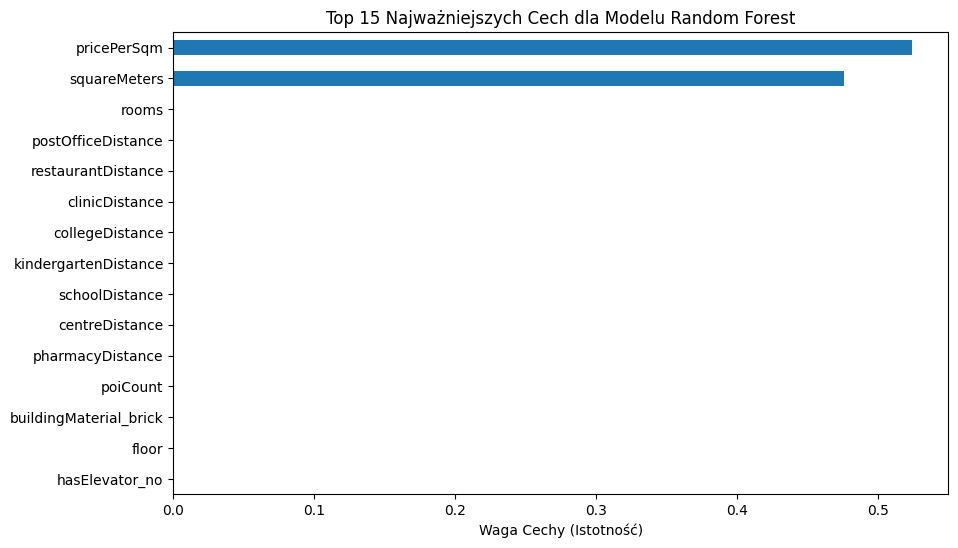


--- Top 5 Najważniejszych Cech ---
pricePerSqm           0.523724
squareMeters          0.475461
rooms                 0.000138
postOfficeDistance    0.000094
restaurantDistance    0.000077
dtype: float64


In [15]:
# Analiza wagi cech dla Random Forest
feature_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)

# Wyświetlenie 15 najważniejszych cech
plt.figure(figsize=(10, 6))
feature_importances.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Najważniejszych Cech dla Modelu Random Forest')
plt.xlabel('Waga Cechy (Istotność)')
plt.show()

print("\n--- Top 5 Najważniejszych Cech ---")
print(feature_importances.nlargest(5))